In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.convnext import preprocess_input
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.regularizers import l2
import warnings
warnings.filterwarnings("ignore")

In [19]:
train_datagen = ImageDataGenerator(
    validation_split=0.1,  # 10% of the data will be used for validation
    preprocessing_function=preprocess_input,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,  # New
    zoom_range=0.2,   # New
    brightness_range=[0.8, 1.2],  # New
    horizontal_flip=True,
    fill_mode='nearest'# it's IMPORTANT
)

In [20]:
train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/train/train_data",
    shuffle = True,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    # Use the training subset
)

validation_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/train/train_data",
    shuffle = False,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'  # Use the validation subset
)

Found 8994 images belonging to 10 classes.
Found 996 images belonging to 10 classes.


In [21]:
model = keras.applications.ConvNeXtLarge(input_shape=(224,224,3),classes=10, weights="imagenet", include_top=False)
for layer in model.layers:
    layer.trainable = False
flatten = keras.layers.Flatten()(model.output)
xx=keras.layers.Dense(units=1000, activation='relu',kernel_regularizer=l2(1e-3))(flatten)
x = keras.layers.Dense(units=10, activation='softmax',kernel_regularizer=l2(1e-3))(xx)
model_cnxl = keras.models.Model(model.input, x)
model_cnxl.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 convnext_large_prestem_nor  (None, 224, 224, 3)          0         ['input_4[0][0]']             
 malization (Normalization)                                                                       
                                                                                                  
 convnext_large_stem (Seque  (None, 56, 56, 192)          9792      ['convnext_large_prestem_norma
 ntial)                                                             lization[0][0]']              
                                                                                            

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.994718 to fit



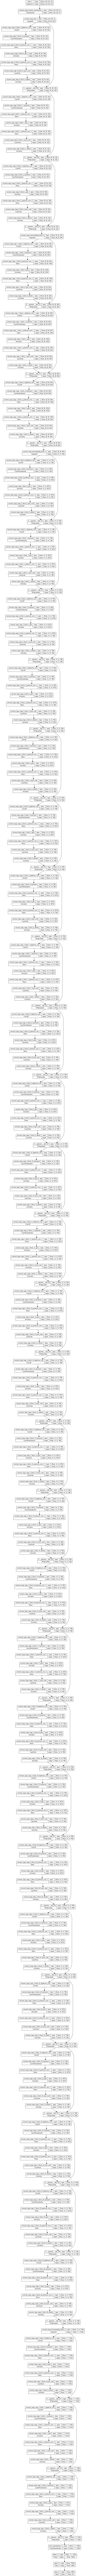

In [22]:
keras.utils.plot_model(model_cnxl, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
model_cnxl.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1e-3),
              metrics='accuracy')

In [24]:
# check= ModelCheckpoint('/content/101v2')
# er_stop=EarlyStopping(min_delta=0.0001,monitor="val_loss",restore_best_weights=True)
lr_pl=ReduceLROnPlateau(monitor="val_accuracy",patience=4,min_delta=0.01,factor=0.05)
train_cnxl = model_cnxl.fit(train_generator,validation_data=validation_generator,epochs=20,callbacks=[lr_pl])

Epoch 1/20
563/563 [==============================] - 1583s 3s/step - loss: 3.6527 - accuracy: 0.5517 - val_loss: 3.1067 - val_accuracy: 0.6205 - lr: 0.0010
Epoch 2/20
563/563 [==============================] - 353s 626ms/step - loss: 2.7492 - accuracy: 0.6551 - val_loss: 2.5303 - val_accuracy: 0.6466 - lr: 0.0010
Epoch 3/20
563/563 [==============================] - 352s 625ms/step - loss: 2.2175 - accuracy: 0.6886 - val_loss: 2.1536 - val_accuracy: 0.6586 - lr: 0.0010
Epoch 4/20
563/563 [==============================] - 351s 624ms/step - loss: 1.8398 - accuracy: 0.7096 - val_loss: 1.9865 - val_accuracy: 0.6536 - lr: 0.0010
Epoch 5/20
563/563 [==============================] - 361s 640ms/step - loss: 1.6797 - accuracy: 0.7235 - val_loss: 1.9435 - val_accuracy: 0.6516 - lr: 0.0010
Epoch 6/20
563/563 [==============================] - 360s 639ms/step - loss: 1.5968 - accuracy: 0.7329 - val_loss: 1.8802 - val_accuracy: 0.6536 - lr: 0.0010
Epoch 7/20
563/563 [============================

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

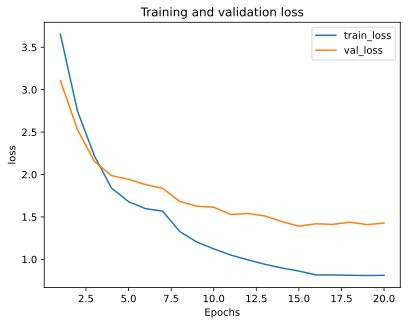

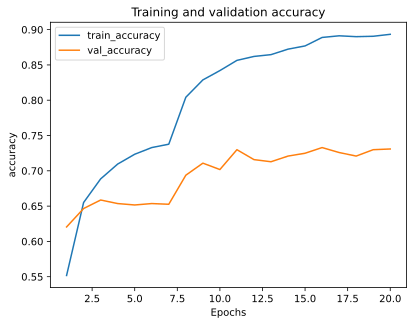

In [26]:
plot_metric(train_cnxl , 'loss')
plot_metric(train_cnxl , 'accuracy')

In [27]:
cnxl=model_cnxl.to_json()#
with open("/content/drive/MyDrive/ConvNeXtLarge_1.json",'w') as json_file:
  json_file.write(cnxl)

model_cnxl.save_weights("/content/drive/MyDrive/ConvNeXtLarge_1.h5")
print(":))))))))))")

:))))))))))
